<a href="https://colab.research.google.com/github/KKundanika/AI-and-Sustainability-Internship/blob/main/Copy_of_K_Kundanika_AI%26Sustainability_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12240 entries, 0 to 12239
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Location   12240 non-null  object 
 1   Filename   12240 non-null  object 
 2   Year       12240 non-null  int64  
 3   Month      12240 non-null  int64  
 4   Day        12240 non-null  int64  
 5   Hour       12240 non-null  object 
 6   AQI        12240 non-null  int64  
 7   PM2.5      12240 non-null  float64
 8   PM10       12240 non-null  float64
 9   O3         11937 non-null  float64
 10  CO         11658 non-null  float64
 11  SO2        10756 non-null  float64
 12  NO2        11802 non-null  float64
 13  AQI_Class  12240 non-null  object 
dtypes: float64(6), int64(4), object(4)
memory usage: 1.3+ MB


/tmp/ipython-input-1705964105.py:29: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12240 entries, 0 to 12239
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Location   12240 non-null  int64         
 1   AQI        12240 non-null  float64       
 2   PM2.5      12240 non-null  float64       
 3   PM10       12240 non-null  float64       
 4   O3         12240 non-null  float64       
 5   CO         12240 non-null  float64       
 6   SO2        12240 non-null  float64       
 7   NO2        12240 non-null  float64       
 8   AQI_Class  12240 non-null  int64         
 9   Datetime   12240 non-null  datetime64[ns]
 10  hour       12240 non-null  int32         
 11  day        12240 non-null  int32         
 12  month      12240 non-null  int32         
 13  weekday    12240 non-null  int32         
dtypes: datetime64[ns](1), float64(7), int32(4), int64(2)
memory usage: 1.1 MB


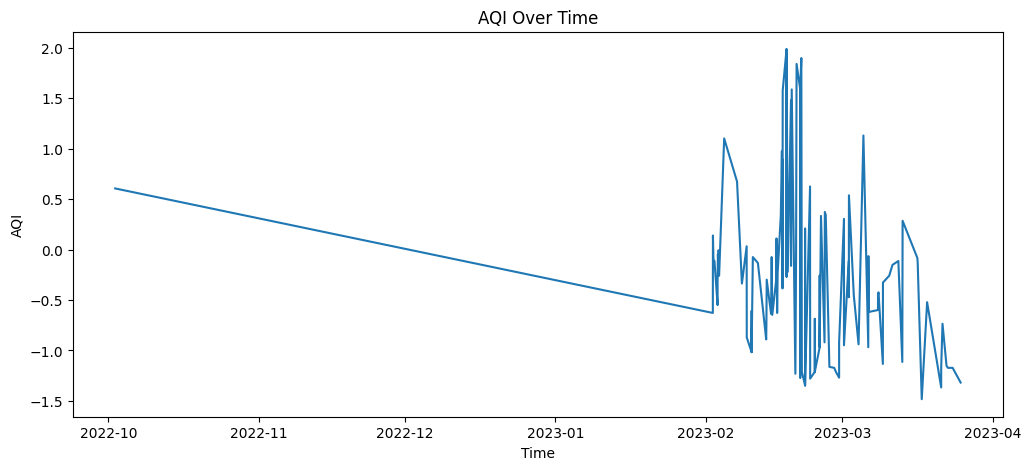

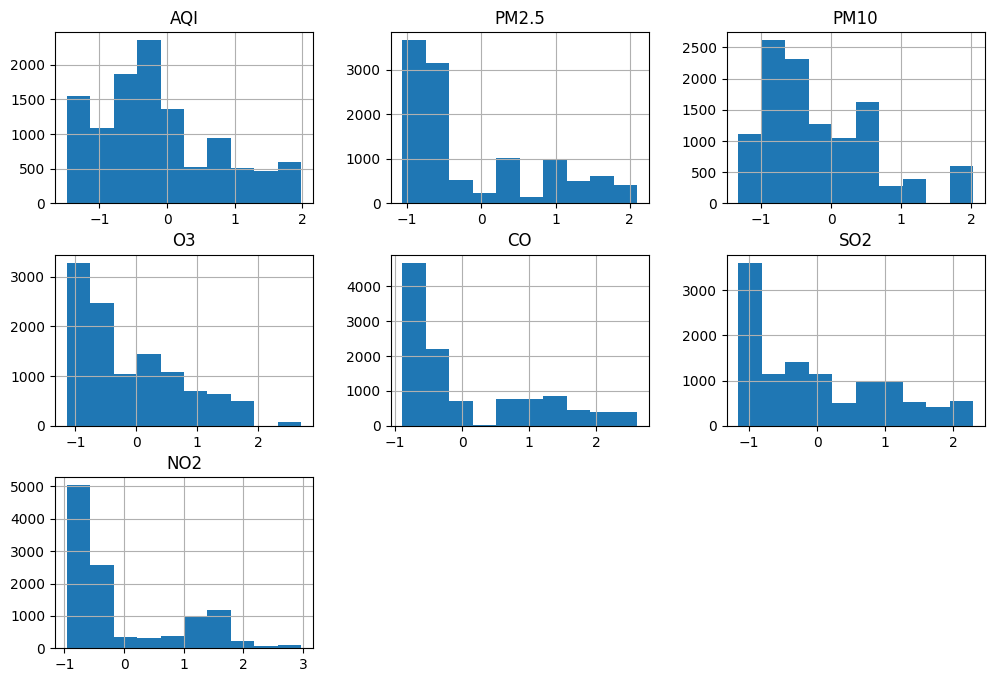

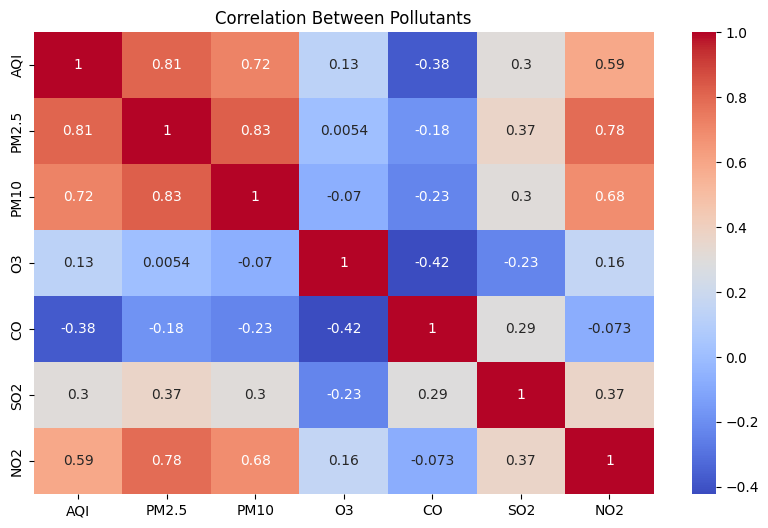

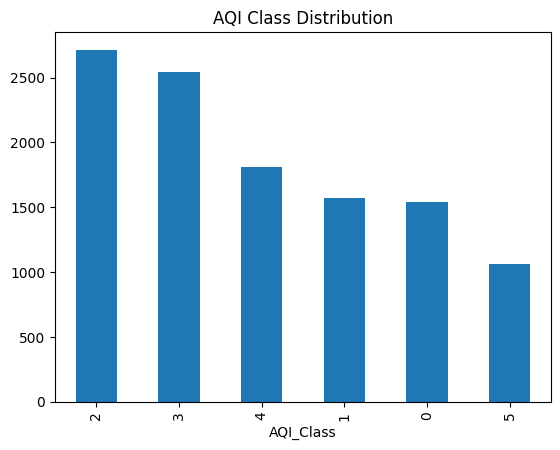

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

file_path = '/content/drive/MyDrive/aqifolder/traindata.csv'
df = pd.read_csv(file_path)

df.head()
df.info()
df.describe()
df.isnull().sum()
df['Hour'].head()
df['Datetime'] = pd.to_datetime(
    df['Year'].astype(str) + '-' +
    df['Month'].astype(str) + '-' +
    df['Day'].astype(str) + ' ' +
    df['Hour'].astype(str),
    errors='coerce'
)
df.drop(['Year','Month','Day','Hour'], axis=1, inplace=True)
df[['Datetime']].head()
df['Datetime'].isnull().sum()
df = df.dropna(subset=['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['month'] = df['Datetime'].dt.month
df['weekday'] = df['Datetime'].dt.weekday
df.interpolate(inplace=True)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Location'] = le.fit_transform(df['Location'])
df['AQI_Class'] = le.fit_transform(df['AQI_Class'])
df.drop('Filename', axis=1, inplace=True)
from sklearn.preprocessing import StandardScaler

num_cols = ['AQI','PM2.5','PM10','O3','CO','SO2','NO2']
df[num_cols] = StandardScaler().fit_transform(df[num_cols])
df.head()
df.info()
df.isnull().sum()
import numpy as np

num_cols = ['AQI','PM2.5','PM10','O3','CO','SO2','NO2']

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower) & (df[col] <= upper)]

df.reset_index(drop=True, inplace=True)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df['Datetime'], df['AQI'])
plt.xlabel("Time")
plt.ylabel("AQI")
plt.title("AQI Over Time")
plt.show()
df[num_cols].hist(figsize=(12,8))
plt.show()
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Pollutants")
plt.show()
df['AQI_Class'].value_counts().plot(kind='bar')
plt.title("AQI Class Distribution")
plt.show()
X = df.drop(['AQI_Class','AQI','Datetime'], axis=1)
y = df['AQI_Class']
df = df.sort_values('Datetime')

split1 = int(len(df)*0.7)
split2 = int(len(df)*0.85)

train_df = df.iloc[:split1]
val_df   = df.iloc[split1:split2]
test_df  = df.iloc[split2:]


X_train = train_df.drop(['AQI_Class','AQI','Datetime'], axis=1)
y_train = train_df['AQI_Class']

X_val = val_df.drop(['AQI_Class','AQI','Datetime'], axis=1)
y_val = val_df['AQI_Class']

X_test = test_df.drop(['AQI_Class','AQI','Datetime'], axis=1)
y_test = test_df['AQI_Class']



In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    #early_stopping_rounds=30,
    verbose=False
)
pred = xgb.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, pred))

Test Accuracy: 0.7059869590989923


In [3]:
for df_ in [train_df, val_df, test_df]:

    df_['PM2.5_roll3'] = df_['PM2.5'].rolling(3).mean()
    df_['PM10_roll3']  = df_['PM10'].rolling(3).mean()
    df_['AQI_roll3']   = df_['AQI'].rolling(3).mean()

    df_['PM2.5_roll6'] = df_['PM2.5'].rolling(6).mean()
    df_['PM10_roll6']  = df_['PM10'].rolling(6).mean()
for df_ in [train_df, val_df, test_df]:
    df_.fillna(method='bfill', inplace=True)
from collections import Counter

print(Counter(y_train))
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

params = {
    'n_estimators': [300, 500, 700],
    'max_depth': [4,6,8,10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.7,0.8,0.9],
    'colsample_bytree': [0.7,0.8,0.9],
    'min_child_weight': [1,3,5]
}

xgb = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42
)

search = RandomizedSearchCV(
    xgb,
    params,
    n_iter=40,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_sm, y_train_sm)

best_model = search.best_estimator_

print("Best Params:", search.best_params_)
val_pred = best_model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_pred))
test_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, test_pred))
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_model,
    X_train_sm,
    y_train_sm,
    cv=5,
    scoring='accuracy'
)

print("CV Accuracy:", cv_scores.mean())


/tmp/ipython-input-2373903818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['PM2.5_roll3'] = df_['PM2.5'].rolling(3).mean()
/tmp/ipython-input-2373903818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['PM10_roll3']  = df_['PM10'].rolling(3).mean()
/tmp/ipython-input-2373903818.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Counter({3: 1819, 2: 1783, 4: 1508, 5: 1064, 1: 946, 0: 750})
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Params: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Validation Accuracy: 0.7557794902193242
Test Accuracy: 0.7095435684647303
CV Accuracy: 0.9196298537192444


In [4]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=5)

scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=tscv,
    scoring='accuracy'
)

print("TimeSeries CV:", scores.mean())
for lag in [1,2,3,6]:
    train_df[f'PM2.5_lag{lag}'] = train_df['PM2.5'].shift(lag)
    train_df[f'PM10_lag{lag}'] = train_df['PM10'].shift(lag)

    val_df[f'PM2.5_lag{lag}'] = val_df['PM2.5'].shift(lag)
    val_df[f'PM10_lag{lag}'] = val_df['PM10'].shift(lag)

    test_df[f'PM2.5_lag{lag}'] = test_df['PM2.5'].shift(lag)
    test_df[f'PM10_lag{lag}'] = test_df['PM10'].shift(lag)
for df_ in [train_df, val_df, test_df]:
    df_.fillna(method='bfill', inplace=True)
X_train = train_df.drop(['AQI_Class','AQI','Datetime'], axis=1)
X_val   = val_df.drop(['AQI_Class','AQI','Datetime'], axis=1)
X_test  = test_df.drop(['AQI_Class','AQI','Datetime'], axis=1)
from xgboost import XGBClassifier

best_model = XGBClassifier(
    n_estimators=600,
    max_depth=4,     # smaller depth
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,   # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    min_child_weight=5,
    eval_metric='mlogloss',
    random_state=42
)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    #early_stopping_rounds=40,
    verbose=False
)
print("Val:", accuracy_score(y_val, best_model.predict(X_val)))
print("Test:", accuracy_score(y_test, best_model.predict(X_test)))


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1763, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expect

TimeSeries CV: nan
Val: 0.8938944872554832
Test: 0.8933017190278602


In [5]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# =========================
# Prepare data
# =========================

drop_cols = ['AQI_Class','AQI','Datetime']

X_train = train_df.drop(drop_cols, axis=1).bfill().ffill()
X_val   = val_df.drop(drop_cols, axis=1).bfill().ffill()
X_test  = test_df.drop(drop_cols, axis=1).bfill().ffill()

y_train = train_df['AQI_Class']
y_val   = val_df['AQI_Class']
y_test  = test_df['AQI_Class']

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

n_classes = len(np.unique(y_train_enc))

# =========================
# Strong tuned XGBoost
# =========================

model = XGBClassifier(
    n_estimators=800,        # more trees (better patterns)
    max_depth=5,             # slightly deeper
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.3,
    reg_lambda=1.0,
    objective='multi:softprob',   # more stable than softmax
    num_class=n_classes,
    eval_metric='mlogloss',
    random_state=42
)

model.fit(
    X_train, y_train_enc,
    eval_set=[(X_val, y_val_enc)],
    #early_stopping_rounds=50,
    verbose=False
)

# =========================
# Evaluate
# =========================

val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val_enc, val_pred))
print("Test Accuracy:", accuracy_score(y_test_enc, test_pred))

print("\nClassification Report:\n")
print(classification_report(y_test_enc, test_pred))


Validation Accuracy: 0.8944872554831061
Test Accuracy: 0.8944872554831061

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       564
           1       0.68      0.61      0.64       254
           2       1.00      0.99      0.99       449
           3       0.99      1.00      0.99       420

    accuracy                           0.89      1687
   macro avg       0.87      0.87      0.87      1687
weighted avg       0.89      0.89      0.89      1687



In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np

# Predicted probabilities
test_probs = model.predict_proba(X_test)

# Classes actually present in test labels
present_classes = np.unique(y_test_enc)

# Binarize y_test only for present classes
y_test_bin = label_binarize(y_test_enc, classes=present_classes)

# Select corresponding probability columns
test_probs_sel = test_probs[:, present_classes]

# Compute ROC AUC safely
roc_auc = roc_auc_score(y_test_bin, test_probs_sel, average='macro')

print("ROC AUC:", roc_auc)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

acc = accuracy_score(y_test_enc, test_pred)
precision = precision_score(y_test_enc, test_pred, average='macro')
recall = recall_score(y_test_enc, test_pred, average='macro')
f1 = f1_score(y_test_enc, test_pred, average='macro')
cm = confusion_matrix(y_test_enc, test_pred)

print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("Confusion Matrix:\n", cm)


ROC AUC: 0.9464610369834885
Accuracy: 0.8944872554831061
Precision: 0.8744047956832539
Recall: 0.8663557923116076
F1: 0.869757412832427
Confusion Matrix:
 [[491  73   0   0]
 [100 154   0   0]
 [  0   0 446   3]
 [  0   0   2 418]]


In [7]:
from xgboost import XGBRegressor

pollutants = ['PM2.5','PM10','NO2','SO2','CO','O3']

feature_cols = [
    'hour','day','month','weekday',
    'PM2.5_roll3','PM10_roll3','AQI_roll3',
    'PM2.5_roll6','PM10_roll6',
    'PM2.5_lag1','PM10_lag1',
    'PM2.5_lag2','PM10_lag2',
    'PM2.5_lag3','PM10_lag3',
    'PM2.5_lag6','PM10_lag6'
]

# Fill missing values safely
train_df[feature_cols] = train_df[feature_cols].bfill().ffill()

regressors = {}

X = train_df[feature_cols]

for pol in pollutants:
    y = train_df[pol]

    reg = XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    )

    reg.fit(X, y)
    regressors[pol] = reg

print("✅ Pollutant forecasting models trained")


/tmp/ipython-input-1125323213.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feature_cols] = train_df[feature_cols].bfill().ffill()


✅ Pollutant forecasting models trained


Dropdown(description='Monitor:', options=('All', np.int64(7), np.int64(0), np.int64(5), np.int64(1)), value='A…

Button(button_style='danger', description='Stop Dashboard', style=ButtonStyle())

╭───────────────────────────────────────────────────── 🌍 7 ──────────────────────────────────────────────────────╮
│ Policy: Soft Mitigation                                                                                         │
│ Alerts: PM10, CO                                                                                                │
│ PM2.5: 23.0 | PM10: 119.0 | NO2: 31.8 | SO2: 70.4 | CO: 6.6 | O3: 3.3                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 🌍 0 ──────────────────────────────────────────────────────╮
│ Policy: Soft Mitigation                                                                                         │
│ Status: Clean                                                                                                   │
│ PM2.5: 14.9 | PM10: 91.4 | NO2: 35.8 | SO2: 23.4 | CO: 3.2 | O3: 24.1                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 🌍 5 ──────────────────────────────────────────────────────╮
│ Policy: Emergency Lockdown                                                                                      │
│ Status: Clean                                                                                                   │
│ PM2.5: 25.7 | PM10: 53.1 | NO2: 33.1 | SO2: 13.1 | CO: 1.3 | O3: 1.9                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 🌍 1 ──────────────────────────────────────────────────────╮
│ Policy: Soft Mitigation                                                                                         │
│ Status: Clean                                                                                                   │
│ PM2.5: 19.9 | PM10: 96.4 | NO2: 0.0 | SO2: 1.9 | CO: 0.0 | O3: 71.5                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📊 KPI OVERVIEW ────────────────────────────────────────────────╮
│ Avg AQI: 31                                                                                                     │
│ Safe Cities: 75.0%                                                                                              │
│ Active Alerts: 2                                                                                                │
│ Model Accuracy: 100.0%                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

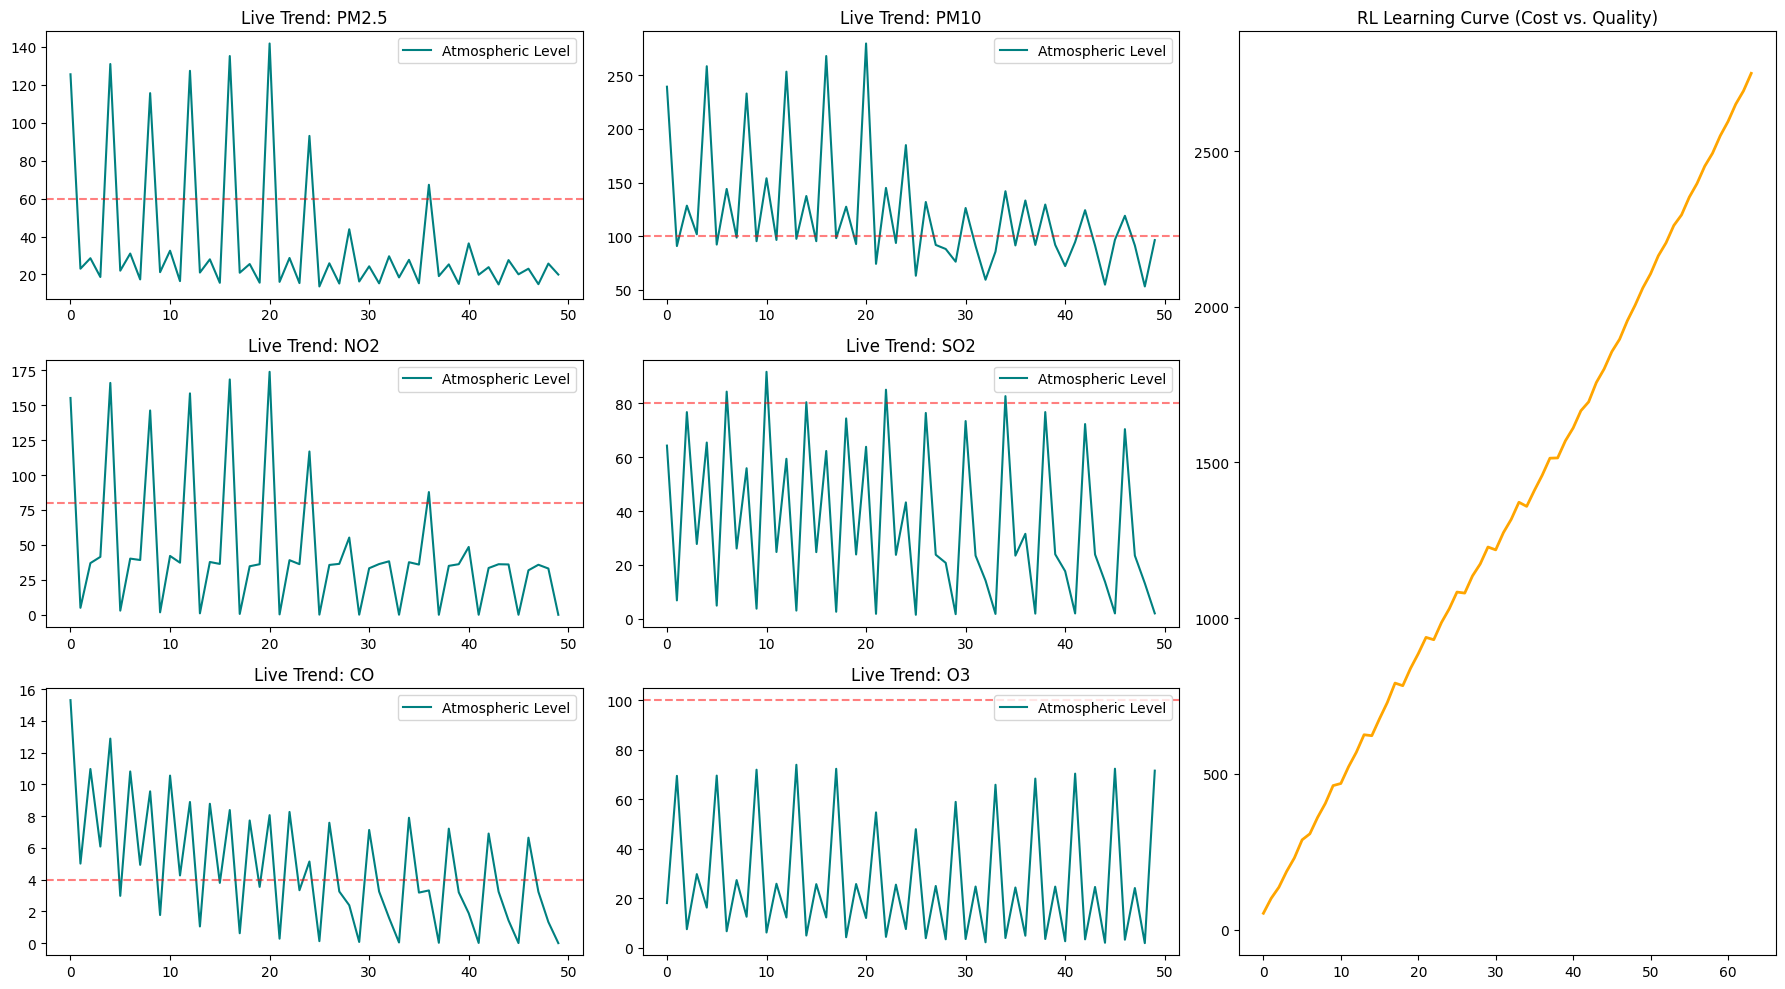

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🛑 Dashboard auto-stopped after 15 cycles.                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [8]:
# ================= INSTALL & IMPORT =================
!pip install xgboost rich ipywidgets -q

from IPython.display import clear_output, display
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import Button, Dropdown

console = Console()

# ================= DATA GENERATOR (In case test_df is missing) =================
# If you already have test_df, you can skip this block.
try:
    df = test_df.copy()
except NameError:
    data = {
        'Location': [f"City_{i}" for i in range(5)] * 100,
        'PM2.5': np.random.uniform(10, 150, 500),
        'PM10': np.random.uniform(20, 250, 500),
        'NO2': np.random.uniform(10, 100, 500),
        'SO2': np.random.uniform(5, 100, 500),
        'CO': np.random.uniform(0.5, 8, 500),
        'O3': np.random.uniform(10, 150, 500)
    }
    df = pd.DataFrame(data)

# ================= PREPROCESSING =================
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']
for p in pollutants:
    df[p] = pd.to_numeric(df[p], errors='coerce')
df = df.dropna(subset=pollutants)

scaler = MinMaxScaler()
aqi_max = np.array([150, 300, 200, 200, 10, 200])
df[pollutants] = scaler.fit_transform(df[pollutants]) * aqi_max
locations = df['Location'].unique()

# Risk labels for XGBoost training
df['risk'] = pd.cut(df[pollutants].mean(axis=1), bins=[0, 60, 90, 120, 1e9], labels=[0, 1, 2, 3]).astype(int)

# ================= TRAIN XGBOOST =================
X, y = df[pollutants], df['risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
xgb_model = XGBClassifier(objective='multi:softmax', num_class=4, n_estimators=100)
xgb_model.fit(X_train, y_train)
ml_accuracy = round(accuracy_score(y_test, xgb_model.predict(X_test)) * 100, 2)

# ================= RL AGENT SETTINGS =================
Q = np.zeros((4, 4)) # States: 4 Risk Levels | Actions: 4 Policies
lr, gamma, epsilon = 0.1, 0.9, 0.15
reward_curve = []

def choose_action(state):
    if random.random() < epsilon: return random.randint(0, 3)
    return np.argmax(Q[state])

# ================= CONFIG & PERSISTENCE =================
THRESH = {'PM2.5': 60, 'PM10': 100, 'NO2': 80, 'SO2': 80, 'CO': 4, 'O3': 100}
POLICY_NAMES = {0: "Normal Ops", 1: "Soft Mitigation", 2: "Heavy Mitigation", 3: "Emergency Lockdown"}

inertia = 0.7  # 70% of pollution persists to the next second
trend = {p: [] for p in pollutants}
# Track the "real" current atmospheric state for each city
city_atmospheres = {loc: {p: 40.0 for p in pollutants} for loc in locations}

# ================= UI =================
stop_flag = False
def stop_loop(b):
    global stop_flag
    stop_flag = True

btn = Button(description="Stop Dashboard", button_style="danger")
btn.on_click(stop_loop)
location_selector = Dropdown(options=["All"] + list(locations), description="Monitor:")

# ================= MAIN SIMULATION LOOP =================
display(location_selector, btn)
i = 0

while not stop_flag and i < 100:
    selected = location_selector.value
    use_locs = locations if selected == "All" else [selected]

    total_aqi_list = []
    safe_count = 0
    alerts_count = 0

    clear_output(wait=True)
    display(location_selector, btn)

    for loc in use_locs:
        # 1. PERCEPTION (Sensor Reading + 5% Noise)
        loc_data = df[df['Location'] == loc]
        raw_row = loc_data.iloc[i % len(loc_data)]
        sensor_perception = {p: float(raw_row[p]) * random.uniform(0.95, 1.05) for p in pollutants}

        # 2. STATE RECOGNITION (XGBoost)
        state_features = np.array(list(sensor_perception.values())).reshape(1, -1)
        perceived_risk = int(xgb_model.predict(state_features)[0])

        # 3. RL ACTION
        action_idx = choose_action(perceived_risk)
        reduction_rate = {0: 0.0, 1: 0.15, 2: 0.35, 3: 0.60}[action_idx]

        # 4. PHYSICS & PERSISTENCE
        current_city_vals = {}
        city_alerts = []
        for p in pollutants:
            # Physical formula: New State = (Inertia * Previous) + (New Source)
            # Then apply Mitigation
            prev_val = city_atmospheres[loc][p]
            new_val = (inertia * prev_val) + ((1 - inertia) * sensor_perception[p])
            actual_val = new_val * (1 - reduction_rate)

            current_city_vals[p] = actual_val
            trend[p].append(actual_val)
            if len(trend[p]) > 50: trend[p].pop(0)

            if actual_val > THRESH[p]:
                city_alerts.append(p)
                alerts_count += 1

        # Update physical memory
        city_atmospheres[loc] = current_city_vals

        # KPI Tracking
        avg_aqi = np.mean(list(current_city_vals.values()))
        total_aqi_list.append(avg_aqi)
        if not city_alerts: safe_count += 1

        # 5. REWARD & LEARN
        # Reward = (Cleanliness) - (Cost of shutting down city)
        reward = (100 - avg_aqi) - (action_idx * 12)
        next_risk = 0 if avg_aqi < 60 else (1 if avg_aqi < 90 else (2 if avg_aqi < 120 else 3))
        Q[perceived_risk, action_idx] += lr * (reward + gamma * np.max(Q[next_risk]) - Q[perceived_risk, action_idx])
        reward_curve.append(reward)

        # 6. UI PANEL
        alert_str = f"[bold red]Alerts: {', '.join(city_alerts)}[/]" if city_alerts else "[green]Status: Clean[/]"
        panel_content = f"Policy: [bold cyan]{POLICY_NAMES[action_idx]}[/]\n{alert_str}\n"
        panel_content += " | ".join([f"{p}: {round(v,1)}" for p, v in current_city_vals.items()])
        console.print(Panel(panel_content, title=f"🌍 {loc}", border_style="blue" if not city_alerts else "red"))

    # ================= KPI OVERVIEW =================
    kpi_panel = Panel(
        f"Avg AQI: {int(np.mean(total_aqi_list))}\nSafe Cities: {round(100*safe_count/len(use_locs),1)}%\n"
        f"Active Alerts: {alerts_count}\nModel Accuracy: {ml_accuracy}%",
        title="📊 KPI OVERVIEW", style="bold white on green"
    )
    console.print(kpi_panel)

    # ================= GRAPHS =================
    plt.figure(figsize=(18, 10))
    gs = GridSpec(3, 3)

    for idx, p in enumerate(pollutants):
        ax = plt.subplot(gs[idx // 2, idx % 2])
        ax.plot(trend[p][-50:], color='teal', label='Atmospheric Level')
        ax.axhline(THRESH[p], color='red', linestyle='--', alpha=0.5)
        ax.set_title(f"Live Trend: {p}")
        ax.legend()

    ax_rl = plt.subplot(gs[:, 2])
    ax_rl.plot(np.cumsum(reward_curve[-300:]), color='orange', linewidth=2)
    ax_rl.set_title("RL Learning Curve (Cost vs. Quality)")

    plt.tight_layout()
    plt.show()

    i += 1
    time.sleep(0.5)
                # ================= FORCED STOP AFTER 15 ITERATIONS =================
    if i > 15:
        console.print(Panel("🛑 Dashboard auto-stopped after 15 cycles.", style="bold red"))
        break